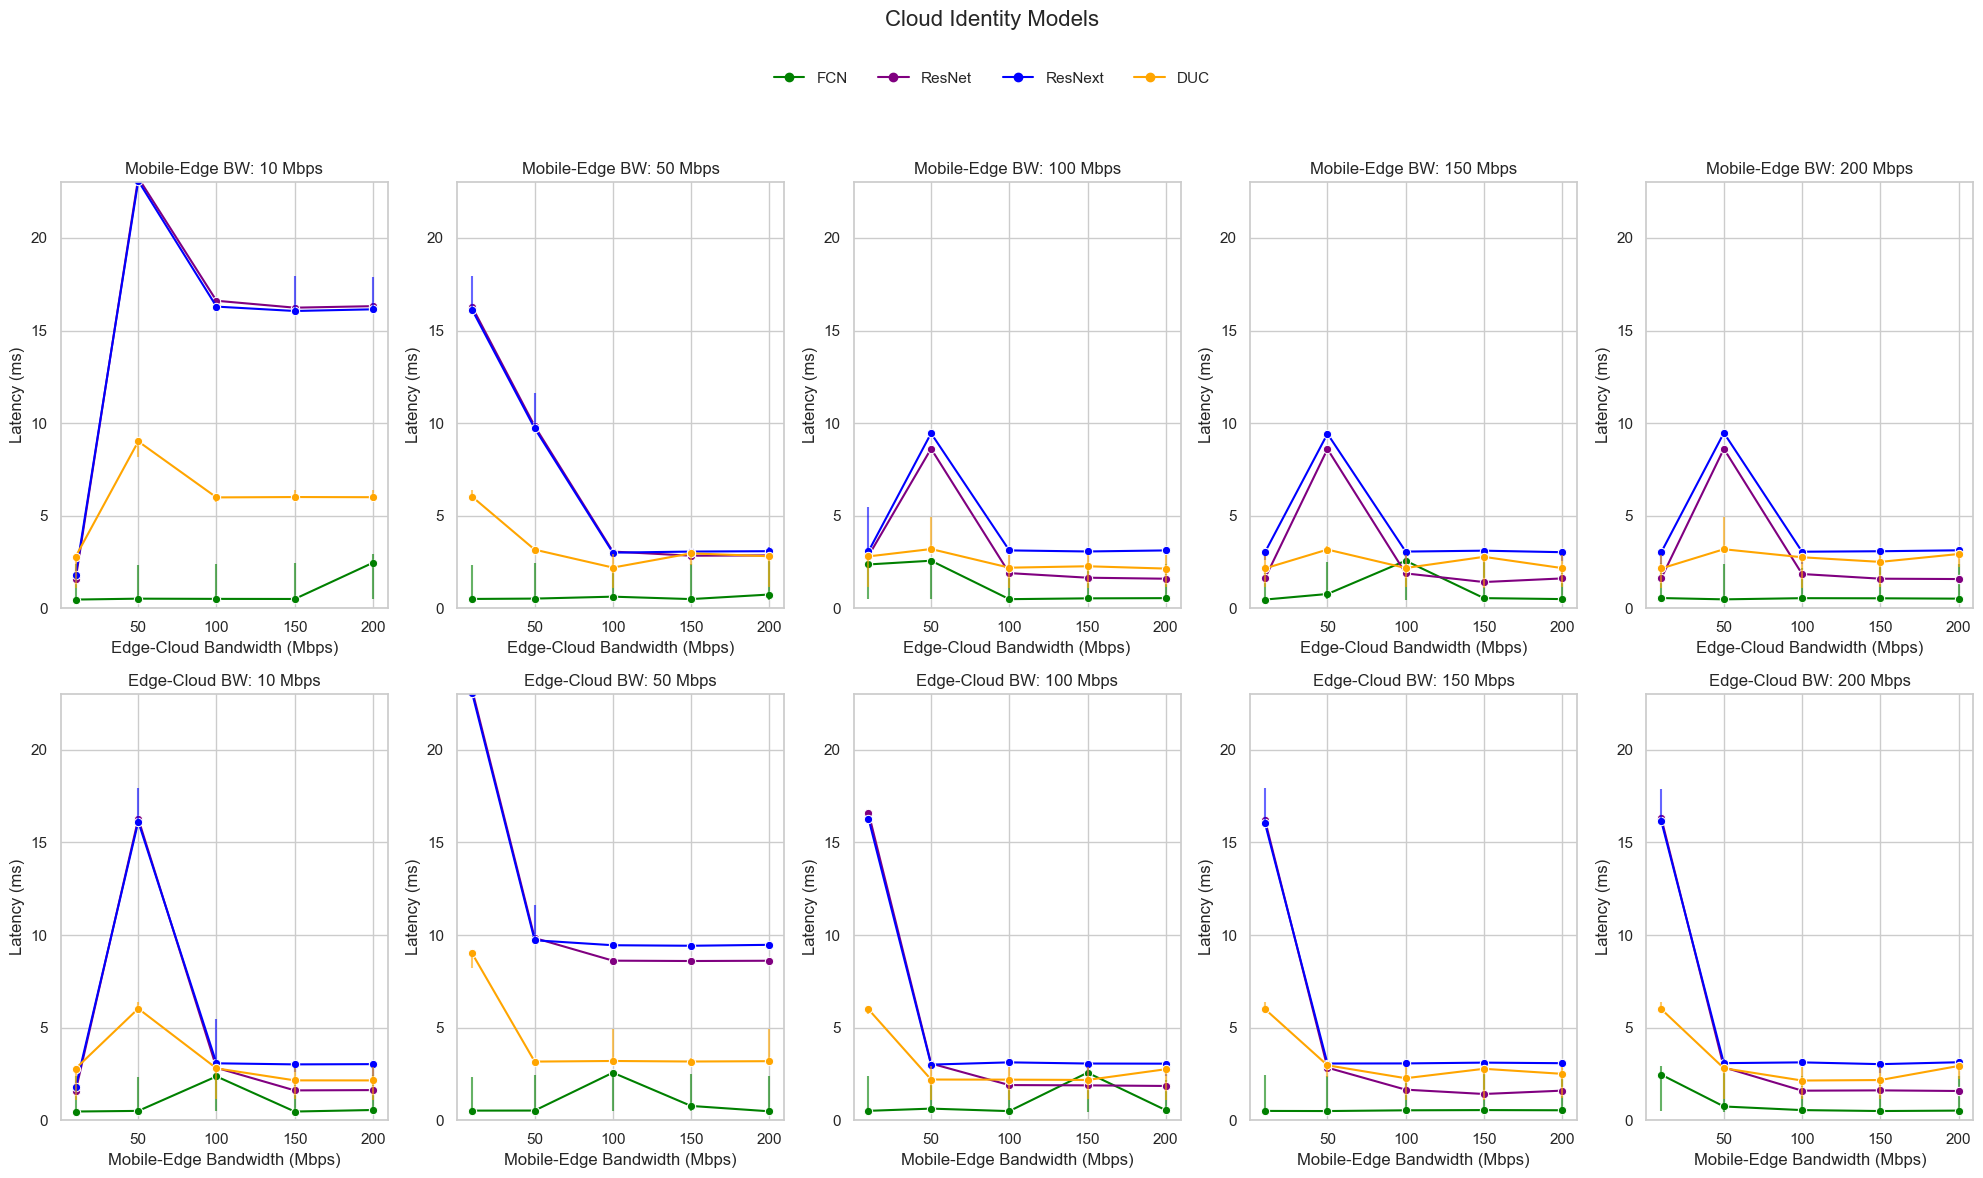

In [2]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        latencies = [float(line.split(", ")[1]) for line in lines if ',' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "cloud_fcn": "cloud_fcn",      # <-- Replace with the actual path for cloud_fcn
    "cloud_resnet": "cloud_resnet",  # <-- Replace with the actual path for cloud_resnet
    "cloud_resnext": "cloud_resnext",  # <-- Replace with the actual path for cloud_resnext
    "cloud_duc":"cloud_duc",
}

# Models to process
models = ["cloud_fcn", "cloud_resnet","cloud_resnext","cloud_duc"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in models}

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    # Iterate through all the txt files in the model folder
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            # Extract bandwidth values from the filename
            parts = filename.split("_")
            mobile_edge_bw = int(parts[2])  # Extract mobile edge bandwidth
            edge_cloud_bw = int(parts[3])   # Extract edge cloud bandwidth
            
            # Get the full file path
            file_path = os.path.join(folder_path, filename)
            
            # Extract the last 5 latencies from the file
            latencies = extract_last_5_latencies(file_path)
            
            # Initialize the dictionary if needed
            if mobile_edge_bw not in latency_data[model]:
                latency_data[model][mobile_edge_bw] = []
            
            # Store the edge-cloud bandwidth and latency samples
            latency_data[model][mobile_edge_bw].append((edge_cloud_bw, latencies))

# Colors for the models
model_colors = {
    "cloud_fcn": "green",
    "cloud_resnet": "purple",
    "cloud_resnext":"blue",
    "cloud_duc":"orange",
}

# Simplified model names for legend
legend_labels = {
    "cloud_fcn": "FCN",
    "cloud_resnet": "ResNet",
    "cloud_resnext":"ResNext",
    "cloud_duc":"DUC",
}

# Set of 5 common mobile-edge bandwidths and edge-cloud bandwidths
mobile_edge_bandwidths = sorted(list(set(mobile_bw for model in models for mobile_bw in latency_data[model].keys())))
edge_cloud_bandwidths = sorted(list(set(ec_bw for model in models for mobile_bw in latency_data[model] for ec_bw, _ in latency_data[model][mobile_bw])))

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold both sets of subplots
fig, (axs1, axs2) = plt.subplots(2, 5, figsize=(20, 12))  # Two rows for both sets of subplots

# 1st set of subplots: Latency vs Edge-Cloud Bandwidth for each Mobile-Edge Bandwidth
for i, mobile_bw in enumerate(mobile_edge_bandwidths):
    ax = axs1[i]  # First row for the first set of subplots
    for model in models:
        if mobile_bw in latency_data[model]:
            data = sorted(latency_data[model][mobile_bw], key=lambda x: x[0])  # Sort by edge-cloud bandwidth
            
            ec_bandwidths = [item[0] for item in data]
            latencies = [item[1] for item in data]
            
            # Calculate medians and confidence intervals
            medians = [np.median(samples) for samples in latencies]
            mins = [np.min(samples) for samples in latencies]
            maxs = [np.max(samples) for samples in latencies]
            
            # Plot the connected line graph for each model
            sns.lineplot(x=ec_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(ec_bandwidths)):
                ax.vlines(x=ec_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    
    ax.set_ylim(0, 23)  # Set Y-axis max to 1.4
    ax.set_xlabel('Edge-Cloud Bandwidth (Mbps)')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Mobile-Edge BW: {mobile_bw} Mbps')
    ax.grid(True)

# 2nd set of subplots: Latency vs Mobile-Edge Bandwidth for each Edge-Cloud Bandwidth
for i, edge_bw in enumerate(edge_cloud_bandwidths):
    ax = axs2[i]  # Second row for the second set of subplots
    for model in models:
        # Collect all mobile-edge bandwidth and latency data for this edge-cloud bandwidth
        x_vals = []
        medians = []
        mins = []
        maxs = []
        
        for mobile_bw, data in latency_data[model].items():
            data = [item for item in data if item[0] == edge_bw]  # Filter by edge-cloud bandwidth
            
            if data:
                latencies = data[0][1]
                
                # Calculate medians and confidence intervals
                median_latency = np.median(latencies)
                min_latency = np.min(latencies)
                max_latency = np.max(latencies)
                
                x_vals.append(mobile_bw)
                medians.append(median_latency)
                mins.append(min_latency)
                maxs.append(max_latency)
        
        # Plot the connected line graph for each model
        if x_vals:
            sns.lineplot(x=x_vals, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(x_vals)):
                ax.vlines(x=x_vals[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    
    ax.set_ylim(0, 23)  # Set Y-axis max to 1.4
    ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Edge-Cloud BW: {edge_bw} Mbps')
    ax.grid(True)

# Adjust layout and leave space for the legend
fig.suptitle('Cloud Identity Models', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.9])
# Create a common legend for both sets of subplots
handles = [plt.Line2D([0], [0], color=model_colors[model], marker='o', linestyle='-', label=legend_labels[model]) for model in models]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False)  # Move the legend slightly lower
# Save the figure as a single image
plt.savefig('cloud_latency_identity.png', dpi=300)
plt.show()

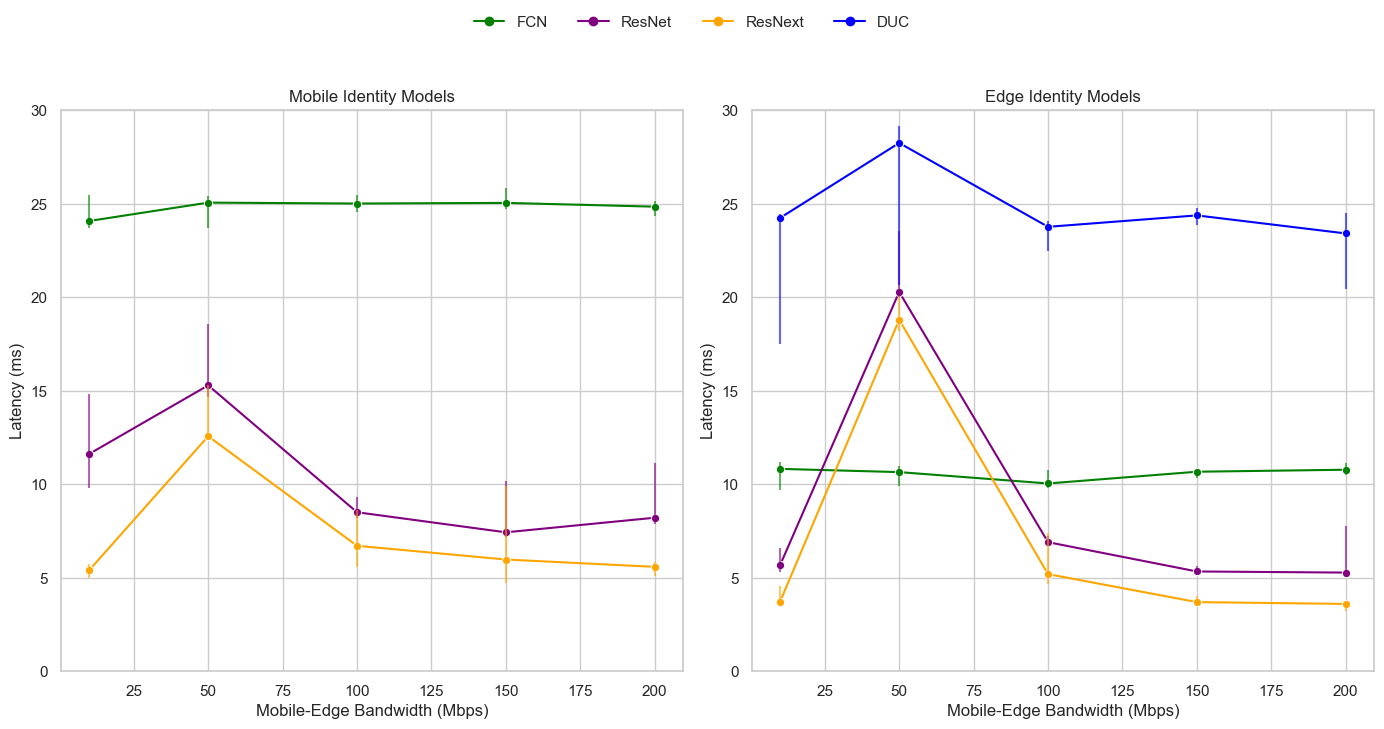

In [7]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        latencies = [float(line.split(", ")[1]) for line in lines if ',' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "mobile_fcn": "mobile_fcn",
    "mobile_resnet": "mobile_resnet",
    "mobile_resnext": "mobile_resnext",
    "mobile_duc": "mobile_duc",
    "edge_fcn": "edge_fcn",
    "edge_resnet": "edge_resnet",
    "edge_resnext": "edge_resnext",
    "edge_duc": "edge_duc"
}

# Split models into mobile and edge models
mobile_models = ["mobile_fcn", "mobile_resnet","mobile_resnext","mobile_duc"]
edge_models = ["edge_fcn", "edge_resnet","edge_resnext","edge_duc"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in mobile_models + edge_models}

# Predefined set of mobile-edge bandwidths (as specified)
mobile_edge_bandwidths = [10, 50, 100, 150, 200]

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            parts = filename.split("_")
            mobile_edge_bw = int(parts[2])  # Extract mobile-edge bandwidth

            if mobile_edge_bw in mobile_edge_bandwidths:  # Ensure it's within the specified bandwidths
                # Get the full file path
                file_path = os.path.join(folder_path, filename)

                # Extract the last 5 latencies from the file
                latencies = extract_last_5_latencies(file_path)

                # Initialize the dictionary if needed
                if mobile_edge_bw not in latency_data[model]:
                    latency_data[model][mobile_edge_bw] = []
                
                # Store the latencies for each mobile-edge bandwidth
                latency_data[model][mobile_edge_bw].append(latencies)

# Colors for the models
model_colors = {
    "mobile_fcn": "green",
    "mobile_resnet": "purple",
    "mobile_resnext": "orange",
    "mobile_duc": "blue",
    "edge_fcn": "green",  
    "edge_resnet": "purple",
    "edge_resnext": "orange",
    "edge_duc": "blue",
}

# Simplified model names for the legend
legend_labels = {
    "fcn": "FCN",
    "resnet": "ResNet",
    "resnext": "ResNext",
    "duc": "DUC"
}

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold two subplots (mobile and edge models)
fig, axs = plt.subplots(1, 2, figsize=(14, 7))  # Two subplots side by side

# 1st subplot: Mobile models (Latency vs Mobile-Edge Bandwidth)
ax = axs[0]
for model in mobile_models:
    medians = []
    mins = []
    maxs = []
    
    for mobile_bw in mobile_edge_bandwidths:
        if mobile_bw in latency_data[model]:
            latencies = latency_data[model][mobile_bw]

            # Calculate medians and confidence intervals
            medians.append(np.median(latencies))
            mins.append(np.min(latencies))
            maxs.append(np.max(latencies))

    # Plot the connected line graph for each model
    sns.lineplot(x=mobile_edge_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model], legend=False)
    for j in range(len(medians)):
        ax.vlines(x=mobile_edge_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)

ax.set_ylim(0, 30)  # Set Y-axis max to 46
ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)')
ax.set_ylabel('Latency (ms)')
ax.set_title('Mobile Identity Models')
ax.grid(True)

# 2nd subplot: Edge models (Latency vs Mobile-Edge Bandwidth)
ax = axs[1]
for model in edge_models:
    medians = []
    mins = []
    maxs = []
    
    for mobile_bw in mobile_edge_bandwidths:
        if mobile_bw in latency_data[model]:
            latencies = latency_data[model][mobile_bw]

            # Calculate medians and confidence intervals
            medians.append(np.median(latencies))
            mins.append(np.min(latencies))
            maxs.append(np.max(latencies))

    # Plot the connected line graph for each model
    sns.lineplot(x=mobile_edge_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model], legend=False)
    for j in range(len(medians)):
        ax.vlines(x=mobile_edge_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)

ax.set_ylim(0, 30)  # Set Y-axis max to 46
ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)')
ax.set_ylabel('Latency (ms)')
ax.set_title('Edge Identity Models')
ax.grid(True)

# Adjust layout and leave space for the legend
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Create a common legend for both subplots
handles = [
    plt.Line2D([0], [0], color="green", marker='o', linestyle='-', label=legend_labels["fcn"]),
    plt.Line2D([0], [0], color="purple", marker='o', linestyle='-', label=legend_labels["resnet"]),
    plt.Line2D([0], [0], color="orange", marker='o', linestyle='-', label=legend_labels["resnext"]),
    plt.Line2D([0], [0], color="blue", marker='o', linestyle='-', label=legend_labels["duc"]),
]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05), frameon=False)
# Save the figure as a single image
plt.savefig('mobile_edge_identity.png', dpi=300)
plt.show()

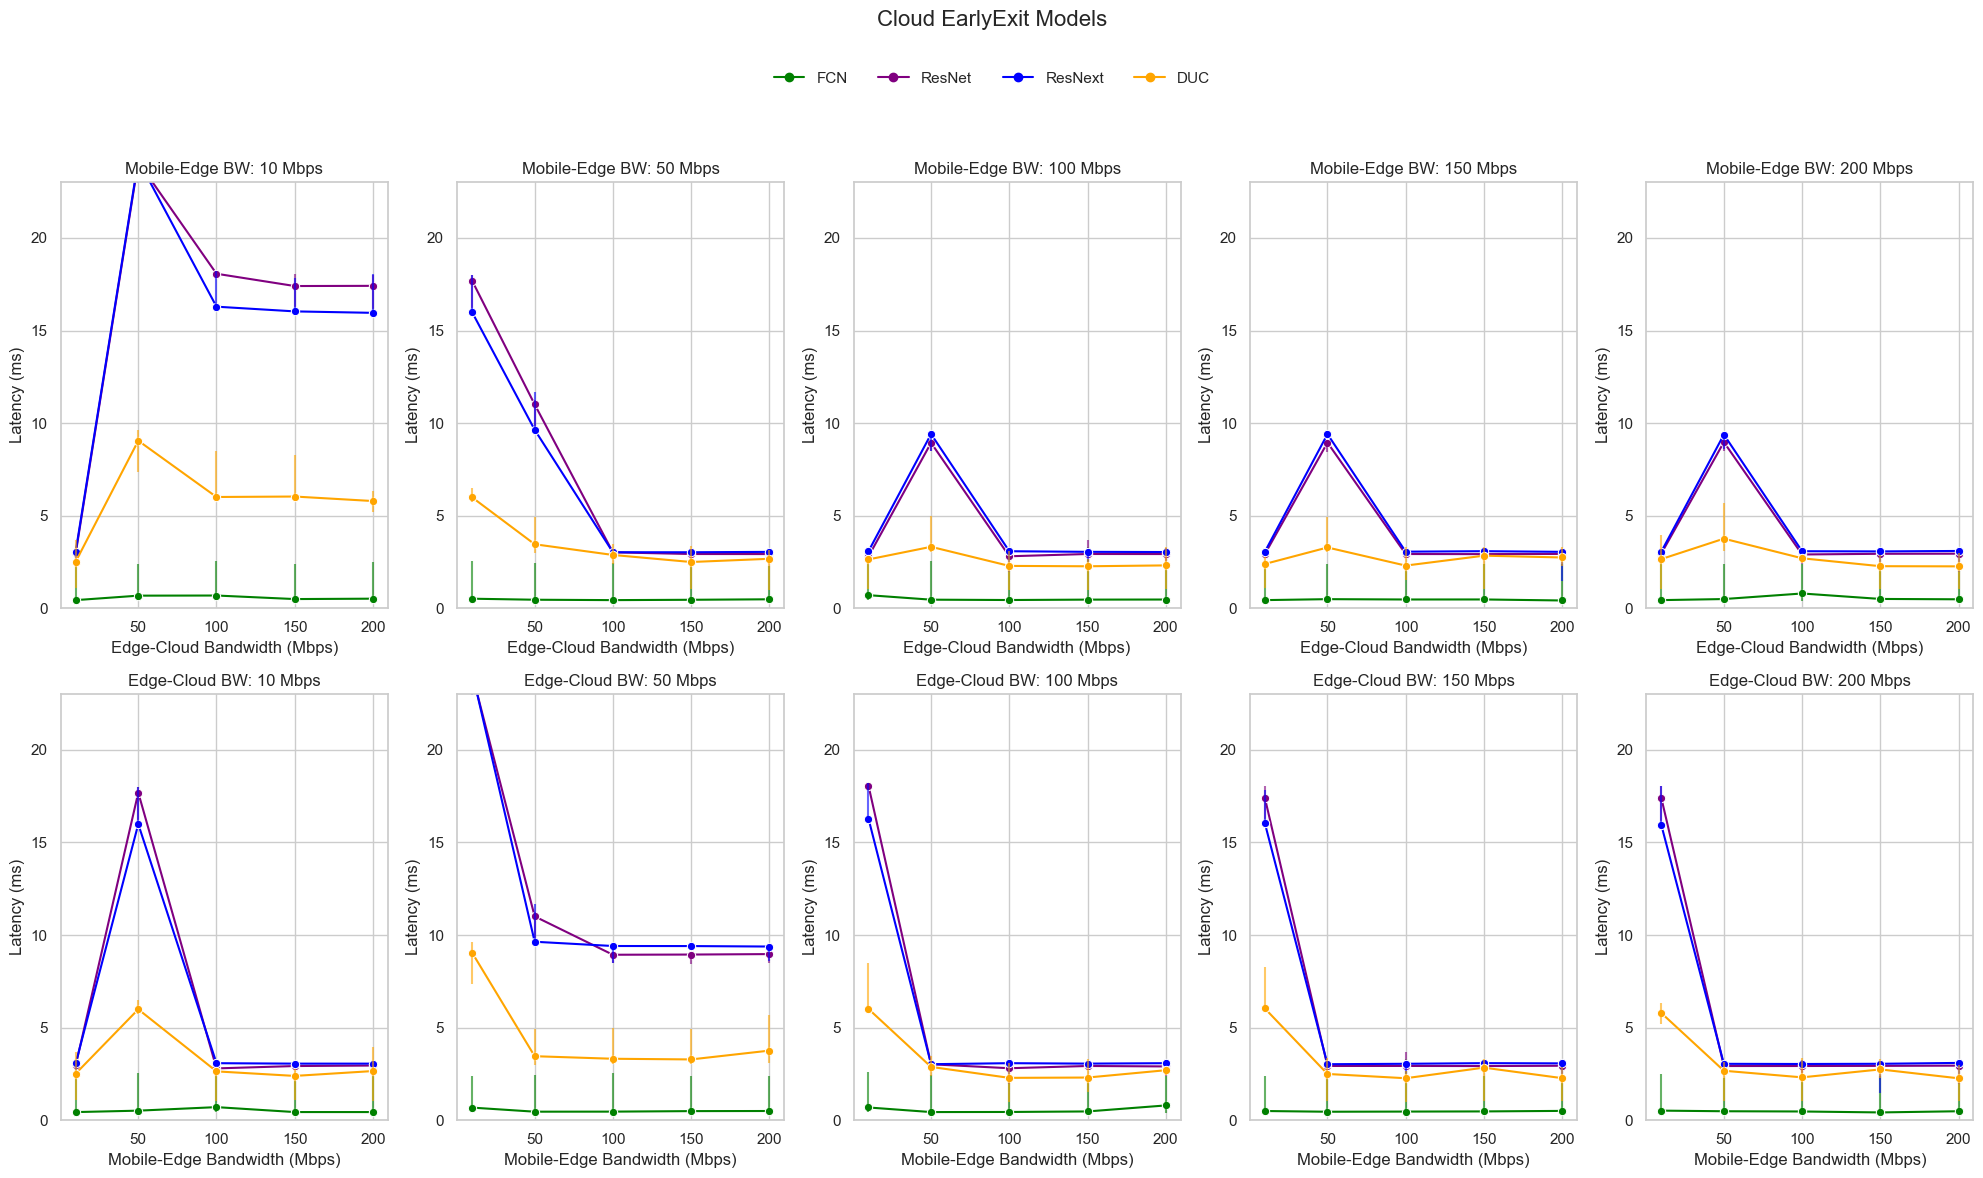

In [17]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        latencies = [float(line.split(", ")[1]) for line in lines if ',' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "cloud_fcn_earlyexit": "cloud_fcn_earlyexit",      # <-- Replace with the actual path for cloud_fcn
    "cloud_resnet_earlyexit": "cloud_resnet_earlyexit",  # <-- Replace with the actual path for cloud_resnet
    "cloud_resnext_earlyexit": "cloud_resnext_earlyexit",  # <-- Replace with the actual path for cloud_resnext
    "cloud_duc_earlyexit":"cloud_duc_earlyexit",
}

# Models to process
models = ["cloud_fcn_earlyexit", "cloud_resnet_earlyexit","cloud_resnext_earlyexit","cloud_duc_earlyexit"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in models}

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    # Iterate through all the txt files in the model folder
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            # Extract bandwidth values from the filename
            parts = filename.split("_")
            mobile_edge_bw = int(parts[3])  # Extract mobile edge bandwidth
            edge_cloud_bw = int(parts[4])   # Extract edge cloud bandwidth
            
            # Get the full file path
            file_path = os.path.join(folder_path, filename)
            
            # Extract the last 5 latencies from the file
            latencies = extract_last_5_latencies(file_path)
            
            # Initialize the dictionary if needed
            if mobile_edge_bw not in latency_data[model]:
                latency_data[model][mobile_edge_bw] = []
            
            # Store the edge-cloud bandwidth and latency samples
            latency_data[model][mobile_edge_bw].append((edge_cloud_bw, latencies))

# Colors for the models
model_colors = {
    "cloud_fcn_earlyexit": "green",
    "cloud_resnet_earlyexit": "purple",
    "cloud_resnext_earlyexit":"blue",
    "cloud_duc_earlyexit":"orange",
}

# Simplified model names for legend
legend_labels = {
    "cloud_fcn_earlyexit": "FCN",
    "cloud_resnet_earlyexit": "ResNet",
    "cloud_resnext_earlyexit":"ResNext",
    "cloud_duc_earlyexit":"DUC",
}

# Set of 5 common mobile-edge bandwidths and edge-cloud bandwidths
mobile_edge_bandwidths = sorted(list(set(mobile_bw for model in models for mobile_bw in latency_data[model].keys())))
edge_cloud_bandwidths = sorted(list(set(ec_bw for model in models for mobile_bw in latency_data[model] for ec_bw, _ in latency_data[model][mobile_bw])))

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold both sets of subplots
fig, (axs1, axs2) = plt.subplots(2, 5, figsize=(20, 12))  # Two rows for both sets of subplots

# 1st set of subplots: Latency vs Edge-Cloud Bandwidth for each Mobile-Edge Bandwidth
for i, mobile_bw in enumerate(mobile_edge_bandwidths):
    ax = axs1[i]  # First row for the first set of subplots
    for model in models:
        if mobile_bw in latency_data[model]:
            data = sorted(latency_data[model][mobile_bw], key=lambda x: x[0])  # Sort by edge-cloud bandwidth
            
            ec_bandwidths = [item[0] for item in data]
            latencies = [item[1] for item in data]
            
            # Calculate medians and confidence intervals
            medians = [np.median(samples) for samples in latencies]
            mins = [np.min(samples) for samples in latencies]
            maxs = [np.max(samples) for samples in latencies]
            
            # Plot the connected line graph for each model
            sns.lineplot(x=ec_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(ec_bandwidths)):
                ax.vlines(x=ec_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    
    ax.set_ylim(0, 23)  # Set Y-axis max to 1.4
    ax.set_xlabel('Edge-Cloud Bandwidth (Mbps)')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Mobile-Edge BW: {mobile_bw} Mbps')
    ax.grid(True)

# 2nd set of subplots: Latency vs Mobile-Edge Bandwidth for each Edge-Cloud Bandwidth
for i, edge_bw in enumerate(edge_cloud_bandwidths):
    ax = axs2[i]  # Second row for the second set of subplots
    for model in models:
        # Collect all mobile-edge bandwidth and latency data for this edge-cloud bandwidth
        x_vals = []
        medians = []
        mins = []
        maxs = []
        
        for mobile_bw, data in latency_data[model].items():
            data = [item for item in data if item[0] == edge_bw]  # Filter by edge-cloud bandwidth
            
            if data:
                latencies = data[0][1]
                
                # Calculate medians and confidence intervals
                median_latency = np.median(latencies)
                min_latency = np.min(latencies)
                max_latency = np.max(latencies)
                
                x_vals.append(mobile_bw)
                medians.append(median_latency)
                mins.append(min_latency)
                maxs.append(max_latency)
        
        # Plot the connected line graph for each model
        if x_vals:
            sns.lineplot(x=x_vals, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(x_vals)):
                ax.vlines(x=x_vals[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    
    ax.set_ylim(0, 23)  # Set Y-axis max to 1.4
    ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Edge-Cloud BW: {edge_bw} Mbps')
    ax.grid(True)

# Adjust layout and leave space for the legend
fig.suptitle('Cloud EarlyExit Models', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.9])
# Create a common legend for both sets of subplots
handles = [plt.Line2D([0], [0], color=model_colors[model], marker='o', linestyle='-', label=legend_labels[model]) for model in models]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False)  # Move the legend slightly lower
# Save the figure as a single image
plt.savefig('cloud_latency_earlyexit.png', dpi=300)
plt.show()

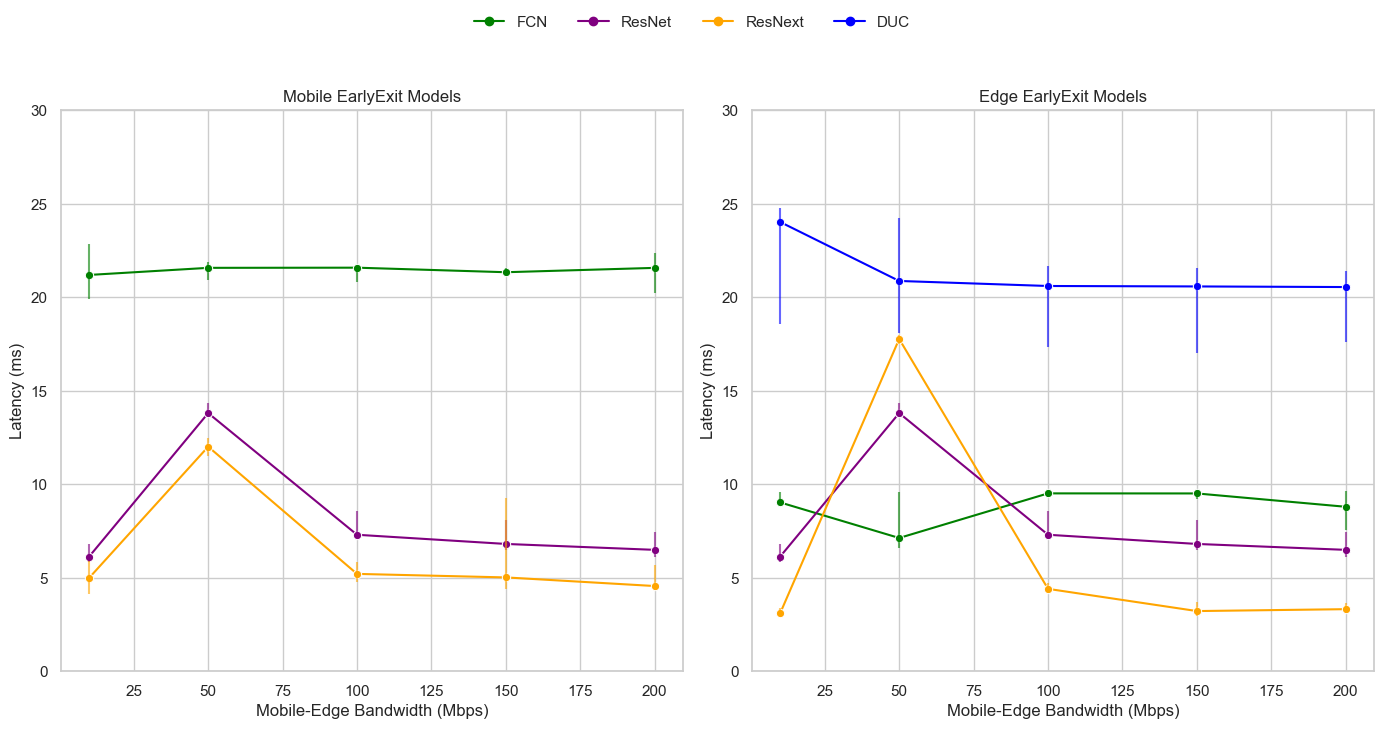

In [18]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        latencies = [float(line.split(", ")[1]) for line in lines if ',' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "mobile_fcn_earlyexit": "mobile_fcn_earlyexit",
    "mobile_resnet_earlyexit": "mobile_resnet_earlyexit",
    "mobile_resnext_earlyexit": "mobile_resnext_earlyexit",
    "mobile_duc_earlyexit": "mobile_duc_earlyexit",
    "edge_fcn_earlyexit": "edge_fcn_earlyexit",
    "edge_resnet_earlyexit": "edge_resnet_earlyexit",
    "edge_resnext_earlyexit": "edge_resnext_earlyexit",
    "edge_duc_earlyexit": "edge_duc_earlyexit"
}

# Split models into mobile and edge models
mobile_models = ["mobile_fcn_earlyexit", "mobile_resnet_earlyexit","mobile_resnext_earlyexit","mobile_duc_earlyexit"]
edge_models = ["edge_fcn_earlyexit", "edge_resnet_earlyexit","edge_resnext_earlyexit","edge_duc_earlyexit"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in mobile_models + edge_models}

# Predefined set of mobile-edge bandwidths (as specified)
mobile_edge_bandwidths = [10, 50, 100, 150, 200]

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            parts = filename.split("_")
            mobile_edge_bw = int(parts[3])  # Extract mobile-edge bandwidth

            if mobile_edge_bw in mobile_edge_bandwidths:  # Ensure it's within the specified bandwidths
                # Get the full file path
                file_path = os.path.join(folder_path, filename)

                # Extract the last 5 latencies from the file
                latencies = extract_last_5_latencies(file_path)

                # Initialize the dictionary if needed
                if mobile_edge_bw not in latency_data[model]:
                    latency_data[model][mobile_edge_bw] = []
                
                # Store the latencies for each mobile-edge bandwidth
                latency_data[model][mobile_edge_bw].append(latencies)

# Colors for the models
model_colors = {
    "mobile_fcn_earlyexit": "green",
    "mobile_resnet_earlyexit": "purple",
    "mobile_resnext_earlyexit": "orange",
    "mobile_duc_earlyexit": "blue",
    "edge_fcn_earlyexit": "green",  
    "edge_resnet_earlyexit": "purple",
    "edge_resnext_earlyexit": "orange",
    "edge_duc_earlyexit": "blue",
}

# Simplified model names for the legend
legend_labels = {
    "fcn": "FCN",
    "resnet": "ResNet",
    "resnext": "ResNext",
    "duc": "DUC"
}

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold two subplots (mobile and edge models)
fig, axs = plt.subplots(1, 2, figsize=(14, 7))  # Two subplots side by side

# 1st subplot: Mobile models (Latency vs Mobile-Edge Bandwidth)
ax = axs[0]
for model in mobile_models:
    medians = []
    mins = []
    maxs = []
    
    for mobile_bw in mobile_edge_bandwidths:
        if mobile_bw in latency_data[model]:
            latencies = latency_data[model][mobile_bw]

            # Calculate medians and confidence intervals
            medians.append(np.median(latencies))
            mins.append(np.min(latencies))
            maxs.append(np.max(latencies))

    # Plot the connected line graph for each model
    sns.lineplot(x=mobile_edge_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model], legend=False)
    for j in range(len(medians)):
        ax.vlines(x=mobile_edge_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)

ax.set_ylim(0, 30)  # Set Y-axis max to 46
ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)')
ax.set_ylabel('Latency (ms)')
ax.set_title('Mobile EarlyExit Models')
ax.grid(True)

# 2nd subplot: Edge models (Latency vs Mobile-Edge Bandwidth)
ax = axs[1]
for model in edge_models:
    medians = []
    mins = []
    maxs = []
    
    for mobile_bw in mobile_edge_bandwidths:
        if mobile_bw in latency_data[model]:
            latencies = latency_data[model][mobile_bw]

            # Calculate medians and confidence intervals
            medians.append(np.median(latencies))
            mins.append(np.min(latencies))
            maxs.append(np.max(latencies))

    # Plot the connected line graph for each model
    sns.lineplot(x=mobile_edge_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model], legend=False)
    for j in range(len(medians)):
        ax.vlines(x=mobile_edge_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)

ax.set_ylim(0, 30)  # Set Y-axis max to 46
ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)')
ax.set_ylabel('Latency (ms)')
ax.set_title('Edge EarlyExit Models')
ax.grid(True)

# Adjust layout and leave space for the legend
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Create a common legend for both subplots
handles = [
    plt.Line2D([0], [0], color="green", marker='o', linestyle='-', label=legend_labels["fcn"]),
    plt.Line2D([0], [0], color="purple", marker='o', linestyle='-', label=legend_labels["resnet"]),
    plt.Line2D([0], [0], color="orange", marker='o', linestyle='-', label=legend_labels["resnext"]),
    plt.Line2D([0], [0], color="blue", marker='o', linestyle='-', label=legend_labels["duc"]),
]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05), frameon=False)
# Save the figure as a single image
plt.savefig('mobile_edge_earlyexit.png', dpi=300)
plt.show()

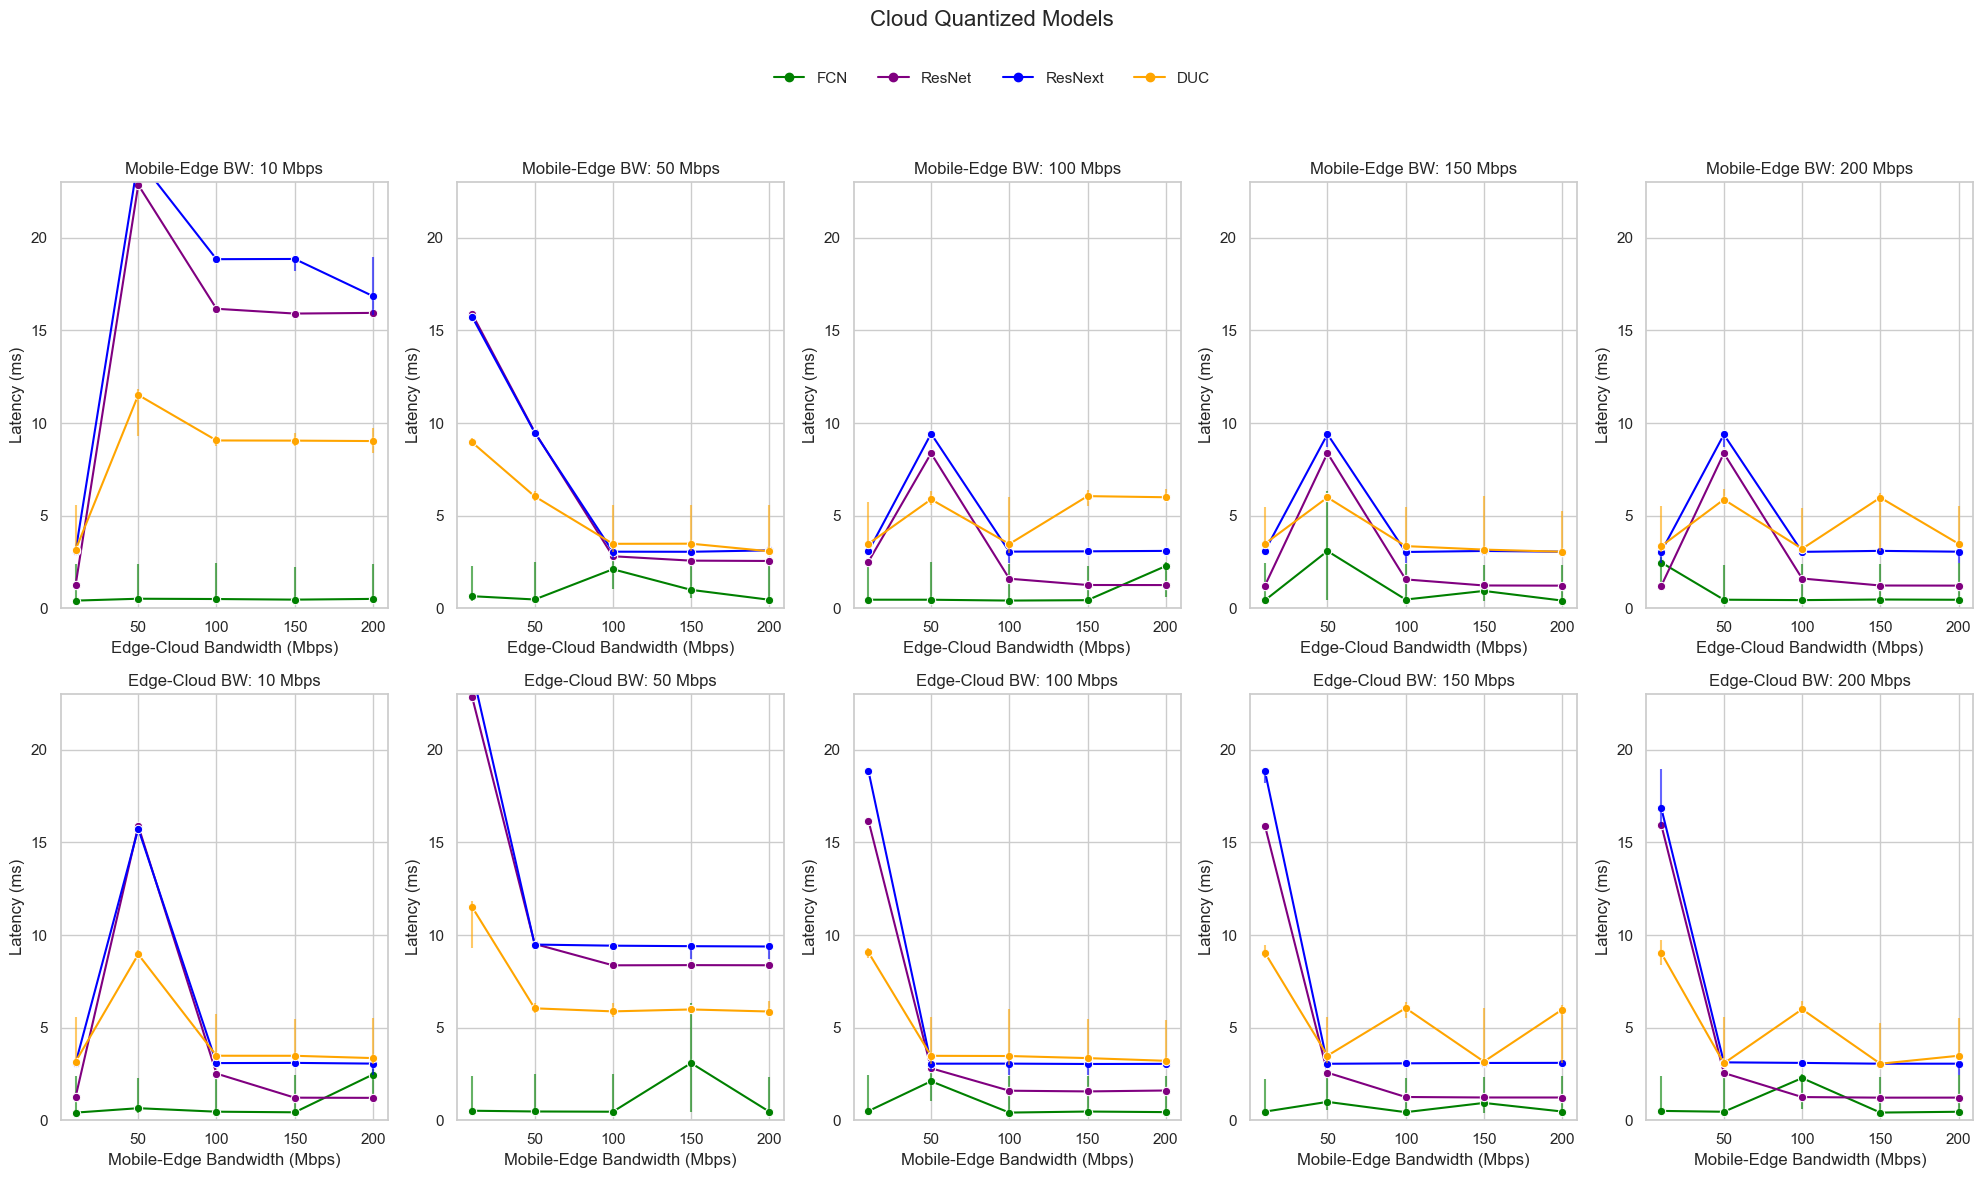

In [3]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        latencies = [float(line.split(", ")[1]) for line in lines if ',' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "cloud_fcn_int8_sptq": "cloud_fcn_int8_sptq",      # <-- Replace with the actual path for cloud_fcn
    "cloud_resnet_int8_sptq": "cloud_resnet_int8_sptq",  # <-- Replace with the actual path for cloud_resnet
    "cloud_resnext_int8_sptq": "cloud_resnext_int8_sptq",  # <-- Replace with the actual path for cloud_resnext
    "cloud_duc_int8_sptq":"cloud_duc_int8_sptq",
}

# Models to process
models = ["cloud_fcn_int8_sptq", "cloud_resnet_int8_sptq","cloud_resnext_int8_sptq","cloud_duc_int8_sptq"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in models}

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    # Iterate through all the txt files in the model folder
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            # Extract bandwidth values from the filename
            parts = filename.split("_")
            mobile_edge_bw = int(parts[4])  # Extract mobile edge bandwidth
            edge_cloud_bw = int(parts[5])   # Extract edge cloud bandwidth
            
            # Get the full file path
            file_path = os.path.join(folder_path, filename)
            
            # Extract the last 5 latencies from the file
            latencies = extract_last_5_latencies(file_path)
            
            # Initialize the dictionary if needed
            if mobile_edge_bw not in latency_data[model]:
                latency_data[model][mobile_edge_bw] = []
            
            # Store the edge-cloud bandwidth and latency samples
            latency_data[model][mobile_edge_bw].append((edge_cloud_bw, latencies))

# Colors for the models
model_colors = {
    "cloud_fcn_int8_sptq": "green",
    "cloud_resnet_int8_sptq": "purple",
    "cloud_resnext_int8_sptq":"blue",
    "cloud_duc_int8_sptq":"orange",
}

# Simplified model names for legend
legend_labels = {
    "cloud_fcn_int8_sptq": "FCN",
    "cloud_resnet_int8_sptq": "ResNet",
    "cloud_resnext_int8_sptq":"ResNext",
    "cloud_duc_int8_sptq":"DUC",
}

# Set of 5 common mobile-edge bandwidths and edge-cloud bandwidths
mobile_edge_bandwidths = sorted(list(set(mobile_bw for model in models for mobile_bw in latency_data[model].keys())))
edge_cloud_bandwidths = sorted(list(set(ec_bw for model in models for mobile_bw in latency_data[model] for ec_bw, _ in latency_data[model][mobile_bw])))

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold both sets of subplots
fig, (axs1, axs2) = plt.subplots(2, 5, figsize=(20, 12))  # Two rows for both sets of subplots

# 1st set of subplots: Latency vs Edge-Cloud Bandwidth for each Mobile-Edge Bandwidth
for i, mobile_bw in enumerate(mobile_edge_bandwidths):
    ax = axs1[i]  # First row for the first set of subplots
    for model in models:
        if mobile_bw in latency_data[model]:
            data = sorted(latency_data[model][mobile_bw], key=lambda x: x[0])  # Sort by edge-cloud bandwidth
            
            ec_bandwidths = [item[0] for item in data]
            latencies = [item[1] for item in data]
            
            # Calculate medians and confidence intervals
            medians = [np.median(samples) for samples in latencies]
            mins = [np.min(samples) for samples in latencies]
            maxs = [np.max(samples) for samples in latencies]
            
            # Plot the connected line graph for each model
            sns.lineplot(x=ec_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(ec_bandwidths)):
                ax.vlines(x=ec_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    
    ax.set_ylim(0, 23)  # Set Y-axis max to 1.4
    ax.set_xlabel('Edge-Cloud Bandwidth (Mbps)')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Mobile-Edge BW: {mobile_bw} Mbps')
    ax.grid(True)

# 2nd set of subplots: Latency vs Mobile-Edge Bandwidth for each Edge-Cloud Bandwidth
for i, edge_bw in enumerate(edge_cloud_bandwidths):
    ax = axs2[i]  # Second row for the second set of subplots
    for model in models:
        # Collect all mobile-edge bandwidth and latency data for this edge-cloud bandwidth
        x_vals = []
        medians = []
        mins = []
        maxs = []
        
        for mobile_bw, data in latency_data[model].items():
            data = [item for item in data if item[0] == edge_bw]  # Filter by edge-cloud bandwidth
            
            if data:
                latencies = data[0][1]
                
                # Calculate medians and confidence intervals
                median_latency = np.median(latencies)
                min_latency = np.min(latencies)
                max_latency = np.max(latencies)
                
                x_vals.append(mobile_bw)
                medians.append(median_latency)
                mins.append(min_latency)
                maxs.append(max_latency)
        
        # Plot the connected line graph for each model
        if x_vals:
            sns.lineplot(x=x_vals, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(x_vals)):
                ax.vlines(x=x_vals[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    
    ax.set_ylim(0, 23)  # Set Y-axis max to 1.4
    ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Edge-Cloud BW: {edge_bw} Mbps')
    ax.grid(True)

# Adjust layout and leave space for the legend
fig.suptitle('Cloud Quantized Models', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.9])
# Create a common legend for both sets of subplots
handles = [plt.Line2D([0], [0], color=model_colors[model], marker='o', linestyle='-', label=legend_labels[model]) for model in models]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False)  # Move the legend slightly lower
# Save the figure as a single image
plt.savefig('cloud_latency_int8_sptq.png', dpi=300)
plt.show()

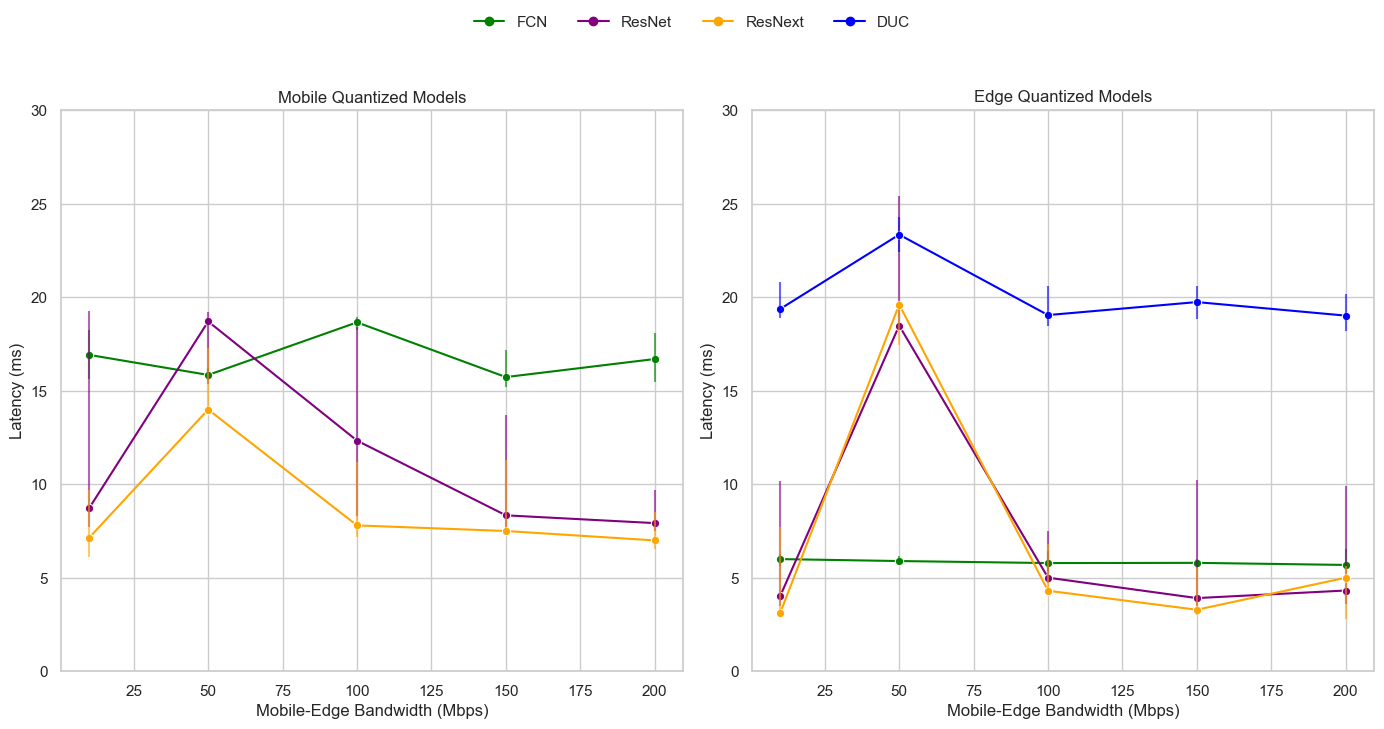

In [9]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        latencies = [float(line.split(", ")[1]) for line in lines if ',' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "mobile_fcn_int8_sptq": "mobile_fcn_int8_sptq",
    "mobile_resnet_int8_sptq": "mobile_resnet_int8_sptq",
    "mobile_resnext_int8_sptq": "mobile_resnext_int8_sptq",
    "mobile_duc_int8_sptq": "mobile_duc_int8_sptq",
    "edge_fcn_int8_sptq": "edge_fcn_int8_sptq",
    "edge_resnet_int8_sptq": "edge_resnet_int8_sptq",
    "edge_resnext_int8_sptq": "edge_resnext_int8_sptq",
    "edge_duc_int8_sptq": "edge_duc_int8_sptq"
}

# Split models into mobile and edge models
mobile_models = ["mobile_fcn_int8_sptq", "mobile_resnet_int8_sptq","mobile_resnext_int8_sptq","mobile_duc_int8_sptq"]
edge_models = ["edge_fcn_int8_sptq", "edge_resnet_int8_sptq","edge_resnext_int8_sptq","edge_duc_int8_sptq"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in mobile_models + edge_models}

# Predefined set of mobile-edge bandwidths (as specified)
mobile_edge_bandwidths = [10, 50, 100, 150, 200]

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            parts = filename.split("_")
            mobile_edge_bw = int(parts[4])  # Extract mobile-edge bandwidth

            if mobile_edge_bw in mobile_edge_bandwidths:  # Ensure it's within the specified bandwidths
                # Get the full file path
                file_path = os.path.join(folder_path, filename)

                # Extract the last 5 latencies from the file
                latencies = extract_last_5_latencies(file_path)

                # Initialize the dictionary if needed
                if mobile_edge_bw not in latency_data[model]:
                    latency_data[model][mobile_edge_bw] = []
                
                # Store the latencies for each mobile-edge bandwidth
                latency_data[model][mobile_edge_bw].append(latencies)

# Colors for the models
model_colors = {
    "mobile_fcn_int8_sptq": "green",
    "mobile_resnet_int8_sptq": "purple",
    "mobile_resnext_int8_sptq": "orange",
    "mobile_duc_int8_sptq": "blue",
    "edge_fcn_int8_sptq": "green",  
    "edge_resnet_int8_sptq": "purple",
    "edge_resnext_int8_sptq": "orange",
    "edge_duc_int8_sptq": "blue",
}

# Simplified model names for the legend
legend_labels = {
    "fcn": "FCN",
    "resnet": "ResNet",
    "resnext": "ResNext",
    "duc": "DUC"
}

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold two subplots (mobile and edge models)
fig, axs = plt.subplots(1, 2, figsize=(14, 7))  # Two subplots side by side

# 1st subplot: Mobile models (Latency vs Mobile-Edge Bandwidth)
ax = axs[0]
for model in mobile_models:
    medians = []
    mins = []
    maxs = []
    
    for mobile_bw in mobile_edge_bandwidths:
        if mobile_bw in latency_data[model]:
            latencies = latency_data[model][mobile_bw]

            # Calculate medians and confidence intervals
            medians.append(np.median(latencies))
            mins.append(np.min(latencies))
            maxs.append(np.max(latencies))

    # Plot the connected line graph for each model
    sns.lineplot(x=mobile_edge_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model], legend=False)
    for j in range(len(medians)):
        ax.vlines(x=mobile_edge_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)

ax.set_ylim(0, 30)  # Set Y-axis max to 46
ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)')
ax.set_ylabel('Latency (ms)')
ax.set_title('Mobile Quantized Models')
ax.grid(True)

# 2nd subplot: Edge models (Latency vs Mobile-Edge Bandwidth)
ax = axs[1]
for model in edge_models:
    medians = []
    mins = []
    maxs = []
    
    for mobile_bw in mobile_edge_bandwidths:
        if mobile_bw in latency_data[model]:
            latencies = latency_data[model][mobile_bw]

            # Calculate medians and confidence intervals
            medians.append(np.median(latencies))
            mins.append(np.min(latencies))
            maxs.append(np.max(latencies))

    # Plot the connected line graph for each model
    sns.lineplot(x=mobile_edge_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model], legend=False)
    for j in range(len(medians)):
        ax.vlines(x=mobile_edge_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)

ax.set_ylim(0, 30)  # Set Y-axis max to 46
ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)')
ax.set_ylabel('Latency (ms)')
ax.set_title('Edge Quantized Models')
ax.grid(True)

# Adjust layout and leave space for the legend
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Create a common legend for both subplots
handles = [
    plt.Line2D([0], [0], color="green", marker='o', linestyle='-', label=legend_labels["fcn"]),
    plt.Line2D([0], [0], color="purple", marker='o', linestyle='-', label=legend_labels["resnet"]),
    plt.Line2D([0], [0], color="orange", marker='o', linestyle='-', label=legend_labels["resnext"]),
    plt.Line2D([0], [0], color="blue", marker='o', linestyle='-', label=legend_labels["duc"]),
]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05), frameon=False)
# Save the figure as a single image
plt.savefig('mobile_edge_sptq.png', dpi=300)
plt.show()

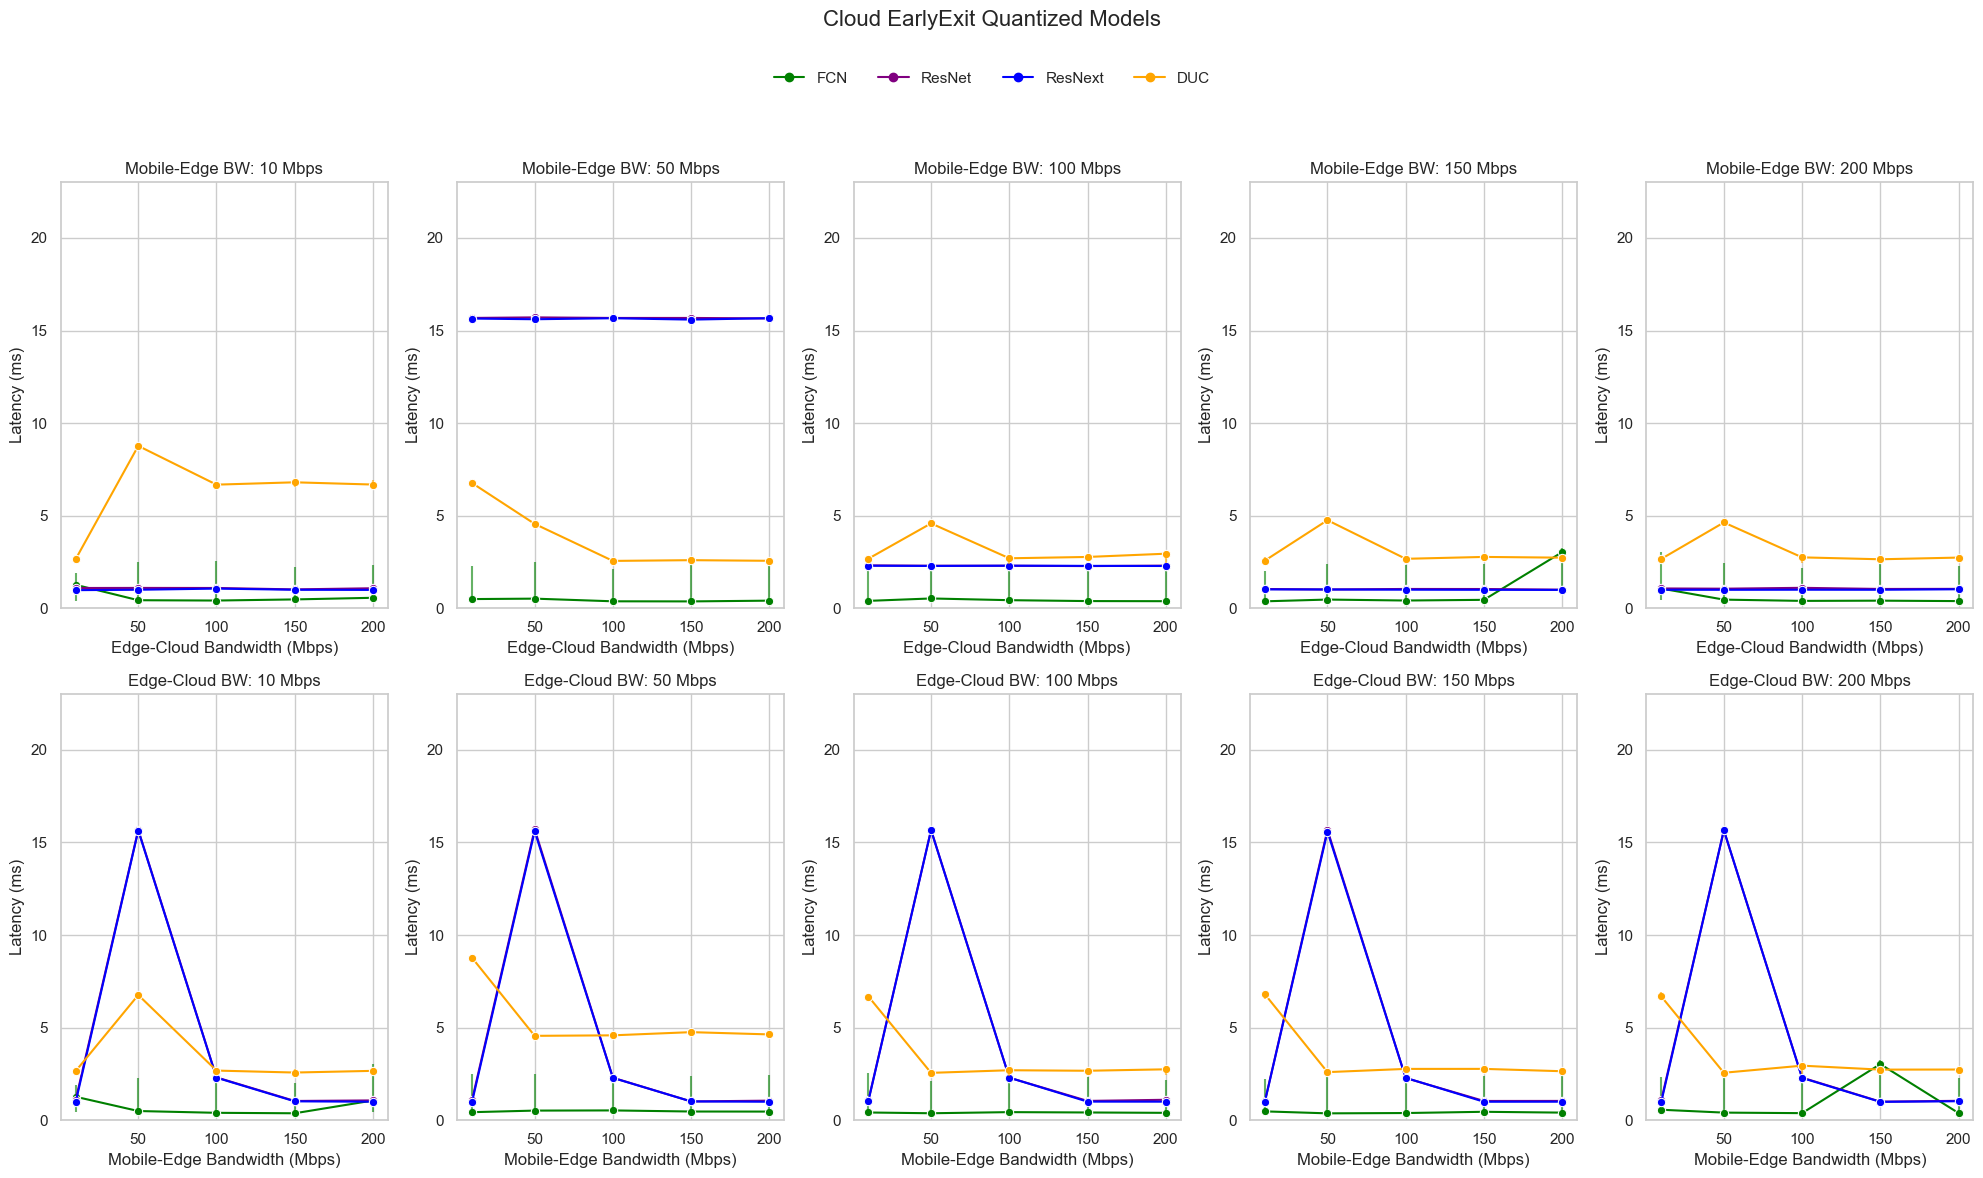

In [15]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        latencies = [float(line.split(", ")[1]) for line in lines if ',' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "cloud_fcn_earlyexit_int8_sptq": "cloud_fcn_earlyexit_int8_sptq",      # <-- Replace with the actual path for cloud_fcn
    "cloud_resnet_earlyexit_int8_sptq": "cloud_resnet_earlyexit_int8_sptq",  # <-- Replace with the actual path for cloud_resnet
    "cloud_resnext_earlyexit_int8_sptq": "cloud_resnext_earlyexit_int8_sptq",  # <-- Replace with the actual path for cloud_resnext
    "cloud_duc_earlyexit_int8_sptq":"cloud_duc_earlyexit_int8_sptq",
}

# Models to process
models = ["cloud_fcn_earlyexit_int8_sptq", "cloud_resnet_earlyexit_int8_sptq","cloud_resnext_earlyexit_int8_sptq","cloud_duc_earlyexit_int8_sptq"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in models}

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    # Iterate through all the txt files in the model folder
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            # Extract bandwidth values from the filename
            parts = filename.split("_")
            mobile_edge_bw = int(parts[5])  # Extract mobile edge bandwidth
            edge_cloud_bw = int(parts[6])   # Extract edge cloud bandwidth
            
            # Get the full file path
            file_path = os.path.join(folder_path, filename)
            
            # Extract the last 5 latencies from the file
            latencies = extract_last_5_latencies(file_path)
            
            # Initialize the dictionary if needed
            if mobile_edge_bw not in latency_data[model]:
                latency_data[model][mobile_edge_bw] = []
            
            # Store the edge-cloud bandwidth and latency samples
            latency_data[model][mobile_edge_bw].append((edge_cloud_bw, latencies))

# Colors for the models
model_colors = {
    "cloud_fcn_earlyexit_int8_sptq": "green",
    "cloud_resnet_earlyexit_int8_sptq": "purple",
    "cloud_resnext_earlyexit_int8_sptq":"blue",
    "cloud_duc_earlyexit_int8_sptq":"orange",
}

# Simplified model names for legend
legend_labels = {
    "cloud_fcn_earlyexit_int8_sptq": "FCN",
    "cloud_resnet_earlyexit_int8_sptq": "ResNet",
    "cloud_resnext_earlyexit_int8_sptq":"ResNext",
    "cloud_duc_earlyexit_int8_sptq":"DUC",
}

# Set of 5 common mobile-edge bandwidths and edge-cloud bandwidths
mobile_edge_bandwidths = sorted(list(set(mobile_bw for model in models for mobile_bw in latency_data[model].keys())))
edge_cloud_bandwidths = sorted(list(set(ec_bw for model in models for mobile_bw in latency_data[model] for ec_bw, _ in latency_data[model][mobile_bw])))

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold both sets of subplots
fig, (axs1, axs2) = plt.subplots(2, 5, figsize=(20, 12))  # Two rows for both sets of subplots

# 1st set of subplots: Latency vs Edge-Cloud Bandwidth for each Mobile-Edge Bandwidth
for i, mobile_bw in enumerate(mobile_edge_bandwidths):
    ax = axs1[i]  # First row for the first set of subplots
    for model in models:
        if mobile_bw in latency_data[model]:
            data = sorted(latency_data[model][mobile_bw], key=lambda x: x[0])  # Sort by edge-cloud bandwidth
            
            ec_bandwidths = [item[0] for item in data]
            latencies = [item[1] for item in data]
            
            # Calculate medians and confidence intervals
            medians = [np.median(samples) for samples in latencies]
            mins = [np.min(samples) for samples in latencies]
            maxs = [np.max(samples) for samples in latencies]
            
            # Plot the connected line graph for each model
            sns.lineplot(x=ec_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(ec_bandwidths)):
                ax.vlines(x=ec_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    
    ax.set_ylim(0, 23)  # Set Y-axis max to 1.4
    ax.set_xlabel('Edge-Cloud Bandwidth (Mbps)')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Mobile-Edge BW: {mobile_bw} Mbps')
    ax.grid(True)

# 2nd set of subplots: Latency vs Mobile-Edge Bandwidth for each Edge-Cloud Bandwidth
for i, edge_bw in enumerate(edge_cloud_bandwidths):
    ax = axs2[i]  # Second row for the second set of subplots
    for model in models:
        # Collect all mobile-edge bandwidth and latency data for this edge-cloud bandwidth
        x_vals = []
        medians = []
        mins = []
        maxs = []
        
        for mobile_bw, data in latency_data[model].items():
            data = [item for item in data if item[0] == edge_bw]  # Filter by edge-cloud bandwidth
            
            if data:
                latencies = data[0][1]
                
                # Calculate medians and confidence intervals
                median_latency = np.median(latencies)
                min_latency = np.min(latencies)
                max_latency = np.max(latencies)
                
                x_vals.append(mobile_bw)
                medians.append(median_latency)
                mins.append(min_latency)
                maxs.append(max_latency)
        
        # Plot the connected line graph for each model
        if x_vals:
            sns.lineplot(x=x_vals, y=medians, marker='o', ax=ax, color=model_colors[model])
            # Plot vertical lines for confidence intervals (min to max latency)
            for j in range(len(x_vals)):
                ax.vlines(x=x_vals[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)
    
    ax.set_ylim(0, 23)  # Set Y-axis max to 1.4
    ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Edge-Cloud BW: {edge_bw} Mbps')
    ax.grid(True)

# Adjust layout and leave space for the legend
fig.suptitle('Cloud EarlyExit Quantized Models', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.9])
# Create a common legend for both sets of subplots
handles = [plt.Line2D([0], [0], color=model_colors[model], marker='o', linestyle='-', label=legend_labels[model]) for model in models]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False)  # Move the legend slightly lower
# Save the figure as a single image
plt.savefig('cloud_latency_earlyexit_int8_sptq.png', dpi=300)
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

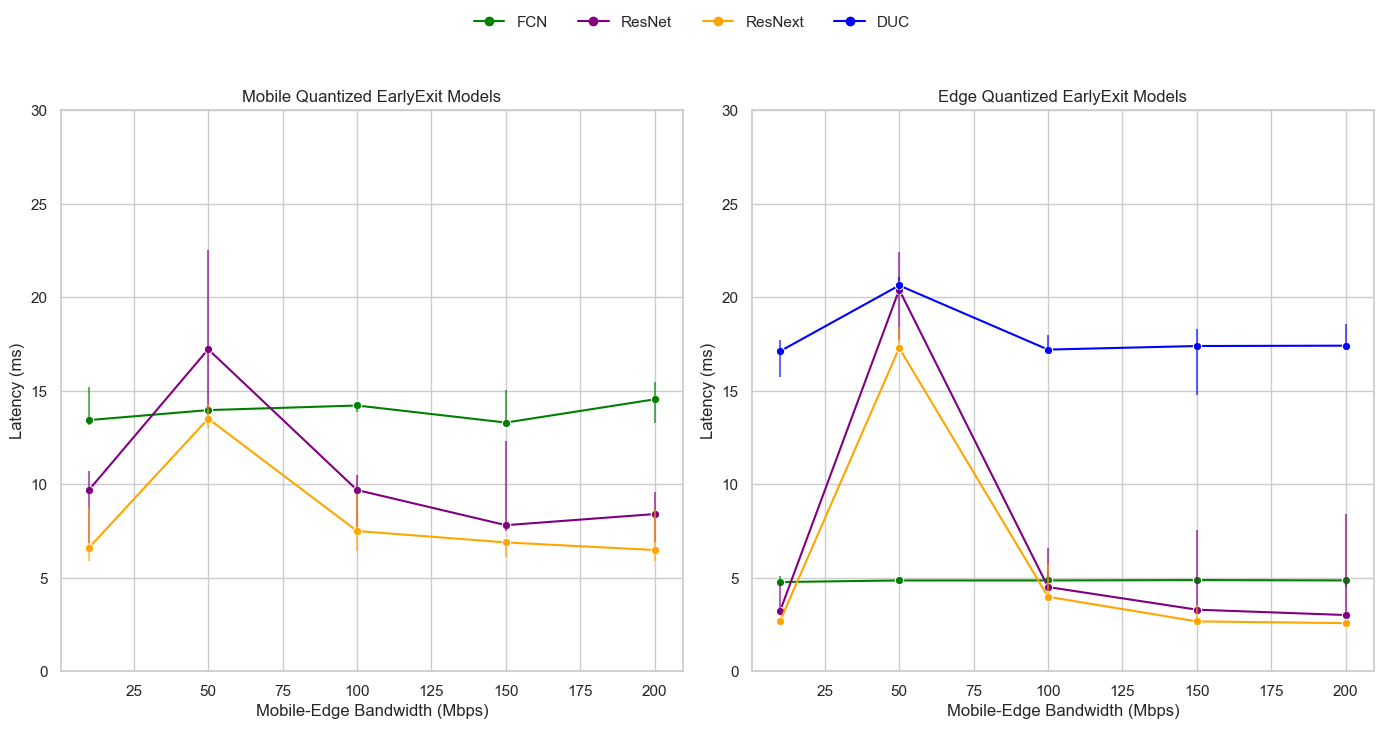

In [6]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract the last 5 latency samples from file content
def extract_last_5_latencies(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        latencies = [float(line.split(", ")[1]) for line in lines if ',' in line]
        return latencies[-5:]  # Get the last 5 latencies

# Define folder paths for each model
folder_paths = {
    "mobile_fcn_earlyexit_int8_sptq": "mobile_fcn_earlyexit_int8_sptq",
    "mobile_resnet_earlyexit_int8_sptq": "mobile_resnet_earlyexit_int8_sptq",
    "mobile_resnext_earlyexit_int8_sptq": "mobile_resnext_earlyexit_int8_sptq",
    "mobile_duc_earlyexit_int8_sptq": "mobile_duc_earlyexit_int8_sptq",
    "edge_fcn_earlyexit_int8_sptq": "edge_fcn_earlyexit_int8_sptq",
    "edge_resnet_earlyexit_int8_sptq": "edge_resnet_earlyexit_int8_sptq",
    "edge_resnext_earlyexit_int8_sptq": "edge_resnext_earlyexit_int8_sptq",
    "edge_duc_earlyexit_int8_sptq": "edge_duc_earlyexit_int8_sptq"
}

# Split models into mobile and edge models
mobile_models = ["mobile_fcn_earlyexit_int8_sptq", "mobile_resnet_earlyexit_int8_sptq","mobile_resnext_earlyexit_int8_sptq","mobile_duc_earlyexit_int8_sptq"]
edge_models = ["edge_fcn_earlyexit_int8_sptq", "edge_resnet_earlyexit_int8_sptq","edge_resnext_earlyexit_int8_sptq","edge_duc_earlyexit_int8_sptq"]

# Dictionary to hold parsed data for each model
latency_data = {model: {} for model in mobile_models + edge_models}

# Predefined set of mobile-edge bandwidths (as specified)
mobile_edge_bandwidths = [10, 50, 100, 150, 200]

# Iterate through each model and its corresponding folder
for model, folder_path in folder_paths.items():
    for filename in os.listdir(folder_path):
        if filename.endswith("_results.txt"):
            parts = filename.split("_")
            mobile_edge_bw = int(parts[5])  # Extract mobile-edge bandwidth

            if mobile_edge_bw in mobile_edge_bandwidths:  # Ensure it's within the specified bandwidths
                # Get the full file path
                file_path = os.path.join(folder_path, filename)

                # Extract the last 5 latencies from the file
                latencies = extract_last_5_latencies(file_path)

                # Initialize the dictionary if needed
                if mobile_edge_bw not in latency_data[model]:
                    latency_data[model][mobile_edge_bw] = []
                
                # Store the latencies for each mobile-edge bandwidth
                latency_data[model][mobile_edge_bw].append(latencies)

# Colors for the models
model_colors = {
    "mobile_fcn_earlyexit_int8_sptq": "green",
    "mobile_resnet_earlyexit_int8_sptq": "purple",
    "mobile_resnext_earlyexit_int8_sptq": "orange",
    "mobile_duc_earlyexit_int8_sptq": "blue",
    "edge_fcn_earlyexit_int8_sptq": "green",  
    "edge_resnet_earlyexit_int8_sptq": "purple",
    "edge_resnext_earlyexit_int8_sptq": "orange",
    "edge_duc_earlyexit_int8_sptq": "blue",
}

# Simplified model names for the legend
legend_labels = {
    "fcn": "FCN",
    "resnet": "ResNet",
    "resnext": "ResNext",
    "duc": "DUC"
}

# Initialize Seaborn style
sns.set(style="whitegrid")

# Create a figure to hold two subplots (mobile and edge models)
fig, axs = plt.subplots(1, 2, figsize=(14, 7))  # Two subplots side by side

# 1st subplot: Mobile models (Latency vs Mobile-Edge Bandwidth)
ax = axs[0]
for model in mobile_models:
    medians = []
    mins = []
    maxs = []
    
    for mobile_bw in mobile_edge_bandwidths:
        if mobile_bw in latency_data[model]:
            latencies = latency_data[model][mobile_bw]

            # Calculate medians and confidence intervals
            medians.append(np.median(latencies))
            mins.append(np.min(latencies))
            maxs.append(np.max(latencies))

    # Plot the connected line graph for each model
    sns.lineplot(x=mobile_edge_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model], legend=False)
    for j in range(len(medians)):
        ax.vlines(x=mobile_edge_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)

ax.set_ylim(0, 30)  # Set Y-axis max to 46
ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)')
ax.set_ylabel('Latency (ms)')
ax.set_title('Mobile Quantized EarlyExit Models')
ax.grid(True)

# 2nd subplot: Edge models (Latency vs Mobile-Edge Bandwidth)
ax = axs[1]
for model in edge_models:
    medians = []
    mins = []
    maxs = []
    
    for mobile_bw in mobile_edge_bandwidths:
        if mobile_bw in latency_data[model]:
            latencies = latency_data[model][mobile_bw]

            # Calculate medians and confidence intervals
            medians.append(np.median(latencies))
            mins.append(np.min(latencies))
            maxs.append(np.max(latencies))

    # Plot the connected line graph for each model
    sns.lineplot(x=mobile_edge_bandwidths, y=medians, marker='o', ax=ax, color=model_colors[model], legend=False)
    for j in range(len(medians)):
        ax.vlines(x=mobile_edge_bandwidths[j], ymin=mins[j], ymax=maxs[j], color=model_colors[model], alpha=0.6)

ax.set_ylim(0, 30)  # Set Y-axis max to 46
ax.set_xlabel('Mobile-Edge Bandwidth (Mbps)')
ax.set_ylabel('Latency (ms)')
ax.set_title('Edge Quantized EarlyExit Models')
ax.grid(True)

# Adjust layout and leave space for the legend
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Create a common legend for both subplots
handles = [
    plt.Line2D([0], [0], color="green", marker='o', linestyle='-', label=legend_labels["fcn"]),
    plt.Line2D([0], [0], color="purple", marker='o', linestyle='-', label=legend_labels["resnet"]),
    plt.Line2D([0], [0], color="orange", marker='o', linestyle='-', label=legend_labels["resnext"]),
    plt.Line2D([0], [0], color="blue", marker='o', linestyle='-', label=legend_labels["duc"]),
]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05), frameon=False)
# Save the figure as a single image
plt.savefig('mobile_edge_earlyexit_sptq.png', dpi=300)
plt.show()